<a href="https://colab.research.google.com/github/Roger-Quinelato/Veggie/blob/main/CIIA_Roger_Quinelato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt_tab')

for dirname, _, filenames in os.walk('/kaggle/input/nlp-getting-started'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

submission = pd.read_csv('/content/sample_submission.csv')
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

submission_df = pd.DataFrame(submission)
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [17]:
# 1. Limpeza do texto

lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words = set(stop_words + ['u', 'im', 'c'])

def clean_text(mensage):
    mensage = str(mensage).lower()
    mensage = re.sub('\[.*?\]', '', mensage)
    mensage = re.sub('https?://\S+|www\.\S+', '', mensage)
    mensage = re.sub(r'@\w+', '', mensage)
    mensage = re.sub('<.*?>+', '', mensage)
    mensage = re.sub('[%s]' % re.escape(string.punctuation), '', mensage)
    mensage = re.sub('\n', '', mensage)
    mensage = re.sub('\w*\d\w*', '', mensage)

    tokens = word_tokenize(mensage)
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(clean_tokens)

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

# 2. Remoção de stopwords


def remove_stopwords(mensage):
    mensage = ' '.join(word for word in mensage.split(' ') if word not in stop_words)
    return mensage

train_df['text'] = train_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(remove_stopwords)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Usando dispositivo: cuda
Iniciando treinamento por 40 épocas...
Época 1/40, Loss: 0.6314
Época 5/40, Loss: 0.4545
Época 10/40, Loss: 0.4088
Época 15/40, Loss: 0.3715
Época 20/40, Loss: 0.3397
Época 25/40, Loss: 0.3213
Época 30/40, Loss: 0.3011
Época 35/40, Loss: 0.2785
Época 40/40, Loss: 0.2652

Avaliando o modelo no conjunto de teste...
Distribuição das previsões finais: {np.float32(0.0): np.int64(990), np.float32(1.0): np.int64(761)}
Acurácia com PyTorch: 0.8104
F1-score com PyTorch: 0.7850

Relatório de Classificação (PyTorch):
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       968
         1.0       0.80      0.77      0.78       783

    accuracy                           0.81      1751
   macro avg       0.81      0.81      0.81      1751
weighted avg       0.81      0.81      0.81      1751



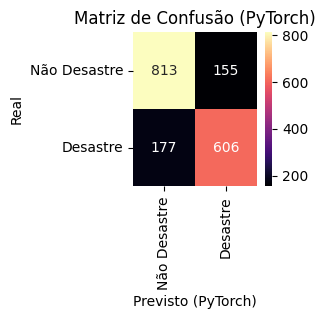

In [18]:
# Divisão dos dados
x = train_df['text']
y = train_df['target']

# Removendo o documento vazio (índice 217)
empty_index = 217
if empty_index in x.index:
    x = x.drop(index=empty_index)
    y = y.drop(index=empty_index)
    y = y.reset_index(drop=True)
    x = x.reset_index(drop=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.23, random_state=19)

# Resetar os índices do x_train e x_test
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

# Carregar o modelo Sentence Transformer para obter embeddings rapidamente
model_name = 'all-mpnet-base-v2'
embedding_model = SentenceTransformer(model_name)

# Gerar os embeddings
x_train_embeddings = embedding_model.encode(x_train, convert_to_tensor=True)
x_test_embeddings = embedding_model.encode(x_test, convert_to_tensor=True)
y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values).float().unsqueeze(1)

# Criar Dataset
class DisasterDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

train_dataset = DisasterDataset(x_train_embeddings, y_train_tensor)
test_dataset = DisasterDataset(x_test_embeddings, y_test_tensor)

# Criar DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Definir o modelo
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 1)

        self.fc2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# 8 - Configurações treinamento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


input_dim = x_train_embeddings.shape[1]
model = SimpleClassifier(input_dim).to(device)
criterion = nn.BCELoss().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Treinar o modelo
epochs = 40
print(f"Iniciando treinamento por {epochs} épocas...")

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    batch_count = 0

    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_count += 1

    # Mostrar progresso a cada 5 épocas
    if (epoch + 1) % 5 == 0 or epoch == 0:
        avg_loss = epoch_loss / batch_count
        print(f'Época {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

        # Verificar distribuição das previsões em uma amostra
        if epoch == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                sample_data = next(iter(train_loader))
                sample_embeddings, sample_labels = sample_data
                sample_embeddings = sample_embeddings.to(device)
                sample_outputs = model(sample_embeddings)
                sample_preds = (sample_outputs > 0.5).float().cpu().numpy()

# Avaliar o modelo
print("\nAvaliando o modelo no conjunto de teste...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings)
        preds = (outputs > 0.4462).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

unique_preds, counts_preds = np.unique(all_preds, return_counts=True)
print(f"Distribuição das previsões finais: {dict(zip(unique_preds, counts_preds))}")

# Calculando métricas

accuracy = accuracy_score(all_labels, all_preds)
f1_pytorch = f1_score(all_labels, all_preds)

print(f'Acurácia com PyTorch: {accuracy:.4f}')
print(f'F1-score com PyTorch: {f1_pytorch:.4f}')

print('\nRelatório de Classificação (PyTorch):')
print(classification_report(all_labels, all_preds))

# Matrix de confusão

cm_pytorch = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(2,2))
sns.heatmap(cm_pytorch, annot=True, fmt='d', cmap='magma',
            xticklabels=['Não Desastre', 'Desastre'],
            yticklabels=['Não Desastre', 'Desastre'])

plt.xlabel('Previsto (PyTorch)')
plt.ylabel('Real')
plt.title('Matriz de Confusão (PyTorch)')
plt.show()